In [5]:
import subprocess
import tensorflow as tf
from tensorflow import summary
import os
import shutil
import json
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import mysql.connector as mysqlpy

# Entraînement du model

## Génération des fichiers .spacy à partir des fichiers JSON

In [10]:
!python scripts/convert.py fr assets/train.json corpus/train.spacy 1
!python scripts/convert.py fr assets/dev.json corpus/dev.spacy 1
!python scripts/convert.py fr assets/test.json corpus/test.spacy 1

[maladie de Behçet]
[syndrome de Stevens-Johnson]
[granulome annulaire]
[diverticulose]
[érythème migrant]
[carcinome à cellules géantes]
[dermatomyosite]
[eczéma dyshidrosique]
[cancer du côlon mucineux]
[cancer du côlon mucineux]
[]
[colite radique]
[syndrome de Sézary]
[carcinome papillaire]
[lymphome de Burkitt]
[carcinoïde colorectal]
[carcinoïde colorectal]
[syndrome de Sézary]
[maladie de Crohn]
[maladie de Crohn]
[lymphome]
[carcinoïde colorectal]
[tumeur stromale gastro-intestinale]
[carcinome à cellules de Merkel]
[mastocytose]
[carcinome adnexal]
[sarcome]
[]
[pityriasis rosé de Gibert]
[sarcome]
[maladie de Bowen]
[syndrome de polypose juvénile]
[lymphome cutané à cellules]
[lichen scléreux]
[tumeur stromale gastro-intestinale]
[syndrome de Peutz-Jeghers]
[]
[carcinome spinocellulaire]
[colite ulcéreuse]
[érythème migrant]
[diverticulose]
[pityriasis versicolor]
[sclérodermie]
[eczéma nummulaire]
[carcinome adénoïde kystique]
[impétigo]
[cancer du côlon métastatique]
[urtic


Map: 100%|██████████| 1142/1142 [00:00<00:00, 2852.42 examples/s]

Map: 100%|██████████| 1142/1142 [00:00<00:00, 4383.68 examples/s]


[lymphome cutané à cellules]
[lymphome de Burkitt]
[pemphigus]
[pityriasis versicolor]
[colite indéterminée]
[colite indéterminée]
[carcinome à cellules de Merkel]
[Maladie de Paget]
[mastocytose]
[cancer du côlon métastatique]
[dermatite herpétiforme]
[maladie de Bowen]
[dermatite de contact]
[syndrome de Sézary]
[syndrome de Stevens-Johnson]
[eczéma nummulaire]
[mastocytose]
[rosacée]
[pityriasis versicolor]
[kératose actinique]
[carcinome adénoïde kystique mucoépidermoïde]
[lichen plan]
[tumeur neuroendocrine]
[sarcome à cellules fusiformes de Kaposi]
[pityriasis rubra pilaire]
[carcinome adénoïde kystique mucoépidermoïde]
[colite ulcéreuse]
[adénome villeux]
[adénome villeux]
[pityriasis rubra pilaire]
[eczéma de contact]
[colite post-infectieuse]
[Kyste pilonidal]
[syndrome de Peutz-Jeghers]
[]
[syndrome de Gougerot-Sjögren]
[acné]
[cancer du côlon mucineux]
[psoriasis]
[]
[eczéma nummulaire]
[colite post-infectieuse]
[lichen plan]
[syndrome de Gougerot-Sjögren]
[polype hyperplasi


Map: 100%|██████████| 364/364 [00:00<00:00, 3639.92 examples/s]

Map: 100%|██████████| 364/364 [00:00<00:00, 5274.85 examples/s]


[lymphome non hodgkinien]
[tumeur neuroendocrine]
[carcinome fibrolamellaire]
[carcinome hépatocellulaire]
[carcinome squirrheux]
[hémangiome]
[tumeur neuroendocrine]
[cancer des canaux biliaires intrahépatiques]
[carcinome fibrolamellaire]
[kyste hépathique]
[kyste hépathique]
[cystadénome]
[carcinome à petites cellules]
[cholangiocarcinome]
[carcinome hépatocellulaire]
[cystadénome]
[cystadénome]
[cancer des canaux biliaires intrahépatiques]
[kyste hépathique]
[adénome]
[cholangiocarcinome]
[carcinome pléomorphe]
[carcinome fibrolamellaire]
[cancer des canaux biliaires intrahépatiques]
[cholangiocarcinome]
[carcinome sarcomatoïde]
[tumeur neuroendocrine]
[cystadénome]
[hémangiome]
[carcinome pléomorphe]
[tumeur neuroendocrine]
[hépatoblastome]
[hépatoblastome]
[lymphome non hodgkinien]
[carcinome à petites cellules]
[adénome]
[carcinome sarcomatoïde]
[carcinome sarcomatoïde]
[carcinome à petites cellules]
[carcinome squirrheux]
[sarcome]
[sarcome]
[hépatoblastome]
[sarcome]
[carcinom

c:\PCO\generate_model\scripts\convert.py:29: UserWarning: Entité ignorée [-1, 10, DIAG] dans le texte suivant car l'étendue des caractères '' ne s'aligne pas sur les limites des jetons:

". Ce type de tumeur est généralement bénin et guéri par l'excision chirurgicale complète. Cependant, des suivis réguliers doivent être pratiqués afin d'éviter toute récidive possible."

  warnings.warn(msg)

Map: 100%|██████████| 141/141 [00:00<00:00, 3064.90 examples/s]

Map: 100%|██████████| 141/141 [00:00<00:00, 4691.32 examples/s]


In [6]:
def renommer_dossier(nom_dossier_a_modifier, dossier_ref):  
    try:        
        nb_dans_dossier_ref = len(os.listdir(dossier_ref))
        nouveau_nom_dossier = f'{nom_dossier_a_modifier}_{nb_dans_dossier_ref + 1}' 
        os.rename(nom_dossier_a_modifier, nouveau_nom_dossier)
        
        print(f"Dossier '{nom_dossier_a_modifier}' a été renommé en '{nouveau_nom_dossier}' avec succès.")

        return nouveau_nom_dossier
    except Exception as e:
        print(f"Une erreur s'est produite lors du renommage du dossier : {e}")

def deplacer_dossier(source, destination):    
    try:
        source_nom_modifie = renommer_dossier(source, destination)
        print('source nom modifie', source_nom_modifie)
        shutil.move(source_nom_modifie, destination)
        print(f"Dossier déplacé de '{source}' vers '{destination}' avec succès.")
    except Exception as e:
        print(f"Une erreur s'est produite lors du déplacement du dossier : {e}")

def tensorboard_log(dossier_parent):
    try:
        dossiers = os.listdir(dossier_parent)
        num_dossier = len(dossiers) + 1
        dossier_log = dossier_parent + '/essai_' + str(num_dossier)
        print(f"Dossier essai_{num_dossier} a été créé avec succès.")
        os.mkdir(dossier_log)
        return dossier_log
    except Exception as e:
        print(f"Une erreur s'est produite lors de la création du dossier : {e}")

def write_log_tensorboard(etap, score, ents_r, ents_p, ents_f, loss_ner, loss_tok2vec):
    tf.summary.scalar('SCORE', float(score), step=int(etap))
    tf.summary.scalar('ENTS_R (rappel)', float(ents_r), step=int(etap))
    tf.summary.scalar('ENTS_P (précision)', float(ents_p), step=int(etap))
    tf.summary.scalar('ENTS_F (score f1)', float(ents_f), step=int(etap))
    tf.summary.scalar('LOSS_NER', float(loss_ner), step=int(etap))
    tf.summary.scalar('LOSS_TOK2VEC', float(loss_tok2vec), step=int(etap))
    

In [ ]:
!spacy project run train

In [4]:
!python -m spacy init fill-config configs/base_config.cfg configs/config.cfg

✔ Auto-filled config with all values
✔ Saved config
configs\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\utilisateur\.netrc


True

## Entrainement et validation

Pour lancer directement tensorboard dans VSC, appuyer sur les touches "Ctrl + Shift + P" puis choisir "lancer TensorBoard", un nouvel onglet s'ouvre.

      # --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --initialize.vectors ${vars.vectors_model} --components.tok2vec.model.embed.include_static_vectors true"


In [7]:
source = r'C:\PCO\generate_model\training'
destination = r'C:\PCO\generate_model\versioning'

# déplace le dossier training précédent dans le dossier training_save, car il doit être effacé pour relancer le modèle.
deplacer_dossier(source, destination)

# création d'un nouveau dossier à chaque fois qu'un nouveau modèle est lancé pour stocker le fichier pour tensorboard
# nécessaire pour lire chaque essai individuellement (autrement ils sont fusionnés !)
dossier_parent = r"C:\PCO\generate_model\log_tensorboard"
dossier_log = tensorboard_log(dossier_parent)

# Créer un objet SummaryWriter pour écrire les fichiers de journal
writer = summary.create_file_writer(dossier_log)

# Récupère les données générées par la commande !spacy project run train
process = subprocess.Popen(["spacy", "project", "run", "train"], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True, encoding='utf-8')

# version jupyter VM
# process = subprocess.Popen(["python", "-m", "spacy", "train", "configs/config.cfg", "--output", "./training", "--paths.train", "./corpus/train.spacy", "--paths.dev", "./corpus/dev.spacy"], 
#                            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True, encoding='utf-8')
for line in process.stdout:
    line = line.rstrip()
    print(line)
    with writer.as_default():         
         epoch = line[0 : 3].strip()         
         if line[0 : 3].strip().isdigit():
            etap = line[6: 11].strip()
            # récupération des différentes métriques au fur et à mesure qu'elles sont générées.
            score = line[-4: -1].strip()
            ents_r = line[-14: -8].strip()
            ents_p = line[-22:-16].strip()
            ents_f = line[-30:-24].strip()
            loss_ner = line[-38:-32].strip()
            loss_tok2vec = line[-49: -42].strip()
            # print('score', score, ',ents_r', ents_r, ',ents_p', ents_p, ',ents_f', ents_f, ',loss_ner', loss_ner, ',loss_tok2vec', loss_tok2vec)
            # introduction des métriques dans le fichier lu par tensorboard en fonction de l'etap.   
            # write_log_tensorboard(etap, score, ents_r, ents_p, ents_f, loss_ner, loss_tok2vec)         
     
# Fermez le processus
process.communicate()
writer.close()

Dossier 'C:\PCO\generate_model\training' a été renommé en 'C:\PCO\generate_model\training_19' avec succès.
source nom modifie C:\PCO\generate_model\training_19
Dossier déplacé de 'C:\PCO\generate_model\training' vers 'C:\PCO\generate_model\versioning' avec succès.
Dossier essai_19 a été créé avec succès.

=================================== train ===================================
Running command: 'C:\PCO\.venv\Scripts\python.exe' -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy
ℹ Saving to output directory: training
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE
---  ------  ------------  --------  ------  ------  ------  ------
wandb: Currently logged

KeyboardInterrupt: 

## Evaluation du modèle.

In [12]:
def lecture_fichier_json(nom_fichier:str):
    try:
        with open(nom_fichier, 'r') as fichier:
            json_file = json.load(fichier)
            return json_file
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier JSON : {e}")
        return None

def ajout_metrics_df(df, metrics:dict):
    df.loc[len(df)] = metrics
    return df    

essai 06 : DIAG   96.20   52.41   67.86<br>
essai 07 : DIAG   92.65   43.45   59.15<br>
essai 08 : DIAG   74.80   63.45   68.66 x10<br> 
essai 09 : DIAG   96.30   35.86   52.26 x20<br> 
essai 10 : DIAG   92.41   50.34   65.18 x10 maxout_pieces = 3<br> 
essai 11 : DIAG   85.71   4.32   8.22 maxout_pieces = 3, diag dans phrase, pas à la fin<br> 
essai 12 : DIAG   94.12   11.51   20.51 x10 maxout_pieces = 3, diag dans phrase, pas à la fin<br> 
essai 14 : DIAG   74.16   47.14   57.64 ??<br>
essai 15 : DIAG   92.86   74.29   82.54 maxout_pieces = 3, diag en fin de phrase + diag = 100<br>
essai 16 : DIAG   88.79   73.57   80.47 maxout_pieces = 3, diag en fin de phrase + diag = 100 fine tuning<br>

In [4]:
!spacy project run evaluate


================================== evaluate ==================================
ℹ Skipping 'evaluate': nothing changed


In [ ]:
def insert_into(essai, taille_train, taille_valid, remarque, hyperparamètre, 
                ents_precision, ents_rappel, ents_scoref1,
                DIAG_precision, DIAG_rappel, DIAG_scoref1,
                PER_precision, PER_rappel, PER_scoref1,
                LOC_precision, LOC_rappel, LOC_scoref1,
                DATE_precision, DATE_rappel, DATE_scoref1):
    user = 'root'
    password = 'example'
    host = 'localhost'
    port = '3307'
    database = 'PCO'
    bdd = mysqlpy.connect(user=user, password=password, host=host, port=port, database=database)

    cursor = bdd.cursor()
    cursor.execute(f'''INSERT INTO metrics (
                   essai, taille_train, taille_valid, remarque, hyperparamètre, 
                   ents_precision, ents_rappel, ents_scoref1,
                   DIAG_precision, DIAG_rappel, DIAG_scoref1,
                   PER_precision, PER_rappel, PER_scoref1,
                   LOC_precision, LOC_rappel, LOC_scoref1,
                   DATE_precision, DATE_rappel, DATE_scoref1)
                   VALUES("{essai}", "{taille_train}", "{taille_valid}", "{remarque}", "{hyperparamètre}", 
                   "{ents_precision}", "{ents_rappel}", "{ents_scoref1}",
                   "{DIAG_precision}", "{DIAG_rappel}", "{DIAG_scoref1}",
                   "{PER_precision}", "{PER_rappel}", "{PER_scoref1}",
                   "{LOC_precision}", "{LOC_rappel}", "{LOC_scoref1}",
                   "{DATE_precision}", "{DATE_rappel}", "{DATE_scoref1}");''')
    bdd.commit()
    cursor.close()
    bdd.close()


In [ ]:
json_metric = r'C:\PCO\generate_model\training\metrics.json'
metrics = lecture_fichier_json(json_metric)

with open('assets/train.json', 'r', encoding='utf-8') as fichier:
    # Charger les données JSON depuis le fichier
    train_json = json.load(fichier)

with open('assets/dev.json', 'r', encoding='utf-8') as fichier:
    # Charger les données JSON depuis le fichier
    valid_json = json.load(fichier)


essai = 'Essai 1'
remarque = ''
taille_train = len(train_json)
taille_valid = len(valid_json)
hyperparameters = 'maxout_pieces = 3'


insert_into(essai, remarque, taille_train, taille_valid, hyperparameters,
            metrics['ents_p'], metrics['ents_r'],  metrics['ents_f'],
            metrics['ents_per_type']['DIAG']['p'], metrics['ents_per_type']['DIAG']['r'],  metrics['ents_per_type']['DIAG']['f'],
            metrics['ents_per_type']['PER']['p'],metrics['ents_per_type']['PER']['r'], metrics['ents_per_type']['PER']['f'],
            metrics['ents_per_type']['LOC']['p'],metrics['ents_per_type']['LOC']['r'], metrics['ents_per_type']['LOC']['f'],
            metrics['ents_per_type']['DATE']['p'], metrics['ents_per_type']['DATE']['r'],  metrics['ents_per_type']['DATE']['f']
            )

In [4]:
from collections import defaultdict
nlp = spacy.load(r"C:\PCO\generate_model\training\model-best")

text = f"""
Résumé anatomopathologique
Patient : Guillaume Samson
Date de naissance : 19/06/1948
Adresse : 611, boulevard Rey, 65501 Saint Anneville
Numéro de sécurité social : 1 1948 06 65501 880 61
Rappels des données personnelles :
L'examen histopathologique a été réalisé sur un échantillon issu d'une biopsie de diverticule colique prélevée sur Guillaume Samson. L'âge du patient était à jour lors de l'intervention chirurgicale.
Description macroscopique :
Le spécimen recevable mesurait environ 3 cm x 2 cm x 1 cm. La muqueuse apparaissait normale, sans signes inflammatoires apparents. Un diverticule simple, mesurant approximativement 1 cm de diamètre, était localisé dans la partie gauche du colon descendant. Son orifice s'ouvrait vers l'intérieur du lumen intestinal. Les marges du diverticule étaient bien définies et il n'y avait pas de signe d'inflammation ou de perforation macroscopique observées.
Description microscopique :
À l'examen microscopique, la muqueuse colique proximal et distal au diverticule apparaitait normale. Cependant, l'épithélium du diverticule présentait des signes d'inflammation chronique, tels que des infiltrats inflammattoires polymorphonucléaires (PMN), des glandes mucosales hypertrophiées et des changements acides des cellules épithéliales. Des bactérias gram-négatives furent identifiées dans les espaces interstitielles entre les glands mucosales. Il y avait également présence de micropolarités et des fibrose sous-jacentes. Aucun cancer ne fut détecté.
Conclusion :
Cet examen histopathologique permet de diagnostiquer une maladie de Lynch. Le diagnostic est confirmé par la présence d'infiltrats inflammatoires polymorphonucléaires, des glandes mucosales hypertrophiques, des modifications acides des cellules épithéliales et des bactéries gram-négatives intraglandulairement. Aucun cancer n'a été repéré.
Signature :
Dr Auguste Bouvier
Note : Ce rapport est fictif."""
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)
    # print(spacy.explain(ent.label_))

maladie de Lynch DIAG


In [6]:
def confusion_matrix_generate(json_test, label):
    nlp = spacy.load(r"C:\PCO\generate_model\training\model-best")
    response_pred = []
    response_valeur = []
    # parcours l'ensemble des CRO
    for i in json_test:
        # récupère le CRO
        text = i[0]
        doc = nlp(text)
        response_list = []
        # fait la prédiction en prenant en compte que le label souhaité 
        for ent in doc.ents:
            if ent.label_ == label:
                response_list.append(ent.text)
        # supprime les réponses en double
        response_model = list(set(response_list))
        # print('predict_model', response_model)

        test_list = []
        # récupère les entités à retrouver dans le texte dans le JSON
        for n in i[1]['entities']:
            if n[2] == label:
                test_list.append(i[0][n[0]: n[1]].lower())
        # supprime les réponse en double
        response_true = list(set(test_list))
        # print('predict attendue', response_true)

        if len(response_true) > 0:
            # print('response attendue pos 0', response_true[0])
            response_valeur.append(response_true[0])
        
        # print('response_valeur', response_valeur)
 
        # compare les prédictions et ce qui doit être trouvé
        intersection_set = set(response_model) & set(response_true)
        # print('intersection predict et vraie', intersection_set)
        resultat = list(intersection_set)
        # print('resultat', resultat)  
        if len(resultat) == 1:  
            print('bien !')
            print(label, response_model, response_true)
            print(text)
            response_pred.append(1)
        # elif label == 'PER' and len(resultat) == 2:
        #     response_pred.append(1)
        else:
            print('pas bien !')
            print(label, response_model, response_true)
            print(text)
            response_pred.append(0)

    
    response_vraie = [1] * len(response_valeur)
    response_vraie = response_vraie + [0] * max(0, len(response_pred) - len(response_vraie))

    if len(list(set(response_pred))) == 1:
        print(f'Pour le label {label} toutes les valeurs sont "vraies positives"')
    else:        
        conf_matrix = confusion_matrix(response_vraie, response_pred)

        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=[0, 1],
                    yticklabels=[0, 1])
        plt.xlabel('Vraies étiquettes')
        plt.ylabel('Prédictions')
        plt.title(f'Matrice de Confusion {label}')
        plt.show()


bien !
DIAG ['lymphome non hodgkinien'] ['lymphome non hodgkinien']
Dans cette observation, nous avons constaté une infiltration tumorale extensive du foie par des lymphocytes B atypiques caractéristiques d'un lymphome non hodgkinien. Cette tumeur est caractérisée par sa morphologie architecturale particulière, avec des aspects papillaires et acanthotiques, ainsi que son profil immunohistochimique spécifique. Une étude plus approfondie devra être effectuée pour évaluer la stade et la gravité de la maladie, notamment en fonction de la taille, de la localisation et de l'extension intraparenchymateuse ou extra-hépaticole. Nous recommandons une consultation multidisciplinaire pour discuter de la meilleure approche thérapeutique adaptée aux particularités cliniques et pathologiques de ce cas.
bien !
DIAG ['tumeur neuroendocrine'] ['tumeur neuroendocrine']
Cette biopsie histologique confirme le diagnostic de tumeur neuroendocrine. Cette finding confirme le diagnostic initial et justifie une 

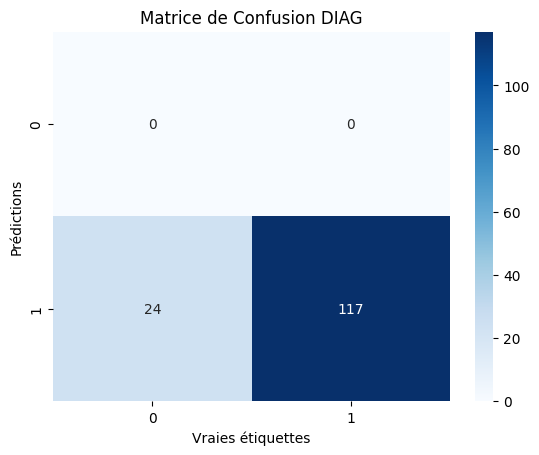

In [7]:
test = r'C:\PCO\generate_model\assets\test.json'
with open(test, 'r', encoding='utf-8') as fichier:
    json_test = json.load(fichier)

# confusion_matrix_generate(json_test, 'LOC')
# confusion_matrix_generate(json_test, 'PER')
# confusion_matrix_generate(json_test, 'DOC')
confusion_matrix_generate(json_test, 'DIAG')
# confusion_matrix_generate(json_test, 'DATE')

Hello, I would like to train a model to recognize diagnoses in anatomical pathology operating accounts in French. The reports were generated by an LLM Mistral IA. The texts were generated from 20 examples of diagnoses. I currently have 1600 operating reports. Here is an example of an operating report in which I want to recover  'hémangiome'.
"Résumé anatomopathologique
Patient : Mme Denise Briand
Date de naissance : 20 novembre 1994
Adresse : 9, rue de Marion, 19795 Lambert
Numéro de sécurité social : 2 1994 11 19795 060 32
Rappels personnels :
Age : 28 ans
Sexe : Femme
Description macroscopique :
L'échantillon reçu mesure environ 3 cm x 2 cm x 1 cm. La coupe transversale montre une masse bien délimitée, rouge foncé et homogène sans capsule distincte. Aucune calcification ni nécrose apparentes.
Description microscopique :
L'étude histologique révèle une prolifération vasculaire maligne disposée en faisceaux et formant des lobules irréguliers. Les vaisseaux sont constitués par des parois épaissies et hyalinisées, avec des cellules endothéliales plasmodiques et nucléolaires abondantes. Des zones d'hémorragie focales sont présentes. Il y a absence de mitoses atypiques ou de signes inflammatoires marqués. L'immunomarqueur CD34 est fortement exprimé dans les cellules endothéliales.
Conclusion :
Dans son ensemble, cette image histologique correspond à un hémangiome bénin du foie. Cette entité est caractérisée par une prolifération vasculaire bien différenciée, avec des parois vascularisées épaissement hyaline et des cellules endothéliales plasmodiques. L'absence de mitoses atypiques et de signes inflammatoires confirme le diagnostic.
Signature :
Dr Paul Pinto
Anatomopathologiste
Note : Ce rapport est fictif."
I tried both possibilities offered by spacy to generate a ner + tok2vec training pipeline but the results are always the same. Example : 
DIAG  P :  87.50 R :  9.30 F : 16.82
Whereas in training I obtain a score of 0.98 and he quickly obtains this score with few epochs.
The 20 diagnostic categories are balanced and I tried to do data augmentation to reach 2000 reports per diagnosis. I also try to play with the hyperparameters, but that doesn't change anything either. 

I thank in advance any answers that will be given.
(text translated with Google trad from French)

Dans la mesure du possible, cette étude histologique fournit des informations supplémentaires sur le diagnostic initial de hépatoblastome basé sur les examens cliniques et radiologiques. L'aspect histologique correspondant à un hépatoblastome de type fetal indique que ce tumeur est généralement plus favorable aux traitements et qu'elle peut avoir une bonne réponse thérapeutique. Cependant, il est important de noter que cette analyse histologique ne remplace pas complètement les autres modalités de diagnostic et de staging, telles que l'imagerie par résonance magnétique (MRI), l'échographie abdominopelvienne et l'analyse moléculaire.
